In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.arima import auto_arima


In [11]:
# Read and preprocess data

aapl = pd.read_csv("data_files/AAPL_combined.csv.gz")
nee = pd.read_csv("data_files/NEE_combined.csv.gz")
lly = pd.read_csv("data_files/LLY_combined.csv.gz")


def data_preprocess(df):
    # Rename columns
    df.rename(columns={'Unnamed: 0': 'timestamp',
                       '1. open': 'open',
                       '2. high': 'high',
                       '3. low': 'low',
                       '4. close': 'close',
                       '5. volume': 'volume'}, inplace=True)
    
    # Drop unnecessary columns
    if 'Unnamed: 0.1' in df.columns.tolist():
        df.drop(columns=['Unnamed: 0.1'], inplace=True)

    # Handle data types
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    return df

aapl = data_preprocess(aapl)
nee = data_preprocess(nee)
lly = data_preprocess(lly)


In [12]:
# Compute daily volatility

def daily_volatility(df):
    """
    Aggregates to daily level and calculates volatility based on the 
    logic: sqrt(log(1 + (close - open) / open))
    """
    # Select columns and drop NAs
    df = df[['timestamp', 'open', 'close']].dropna().copy()
    
    # Convert timestamp to datetime and extract the date
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    
    # Group by date to get first open and last close
    daily = df.groupby('date').agg(
        open=('open', 'first'),
        close=('close', 'last')
    ).reset_index()
    
    # Calculate log return
    # equivalent to R: log(1 + (close - open) / open) -> log(close / open)
    daily['log_return'] = np.log(1 + (daily['close'] - daily['open']) / daily['open'])
    
    # Calculate volatility
    # Note: If log_return is negative, sqrt will result in NaN. 
    # We use np.sqrt where valid, otherwise NaN.
    daily['volatility'] = daily['log_return'].apply(lambda x: np.sqrt(x) if x > 0 else np.nan)
    
    # Return only date and volatility, dropping any rows where calculation failed (NaNs)
    return daily[['date', 'volatility']].dropna()

aapl_vol = daily_volatility(aapl)
nee_vol = daily_volatility(nee)
lly_vol = daily_volatility(lly)


--- Auto ARIMA for AAPL ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  775
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1305.051
Date:                Sun, 07 Dec 2025   AIC                          -2606.102
Time:                        20:35:17   BIC                          -2596.799
Sample:                             0   HQIC                         -2602.523
                                - 775                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9425      0.011    -82.846      0.000      -0.965      -0.920
sigma2         0.0020   7.28e-05     27.529      0.000       0.002       0.002
Ljung-Box (L1) (Q):     

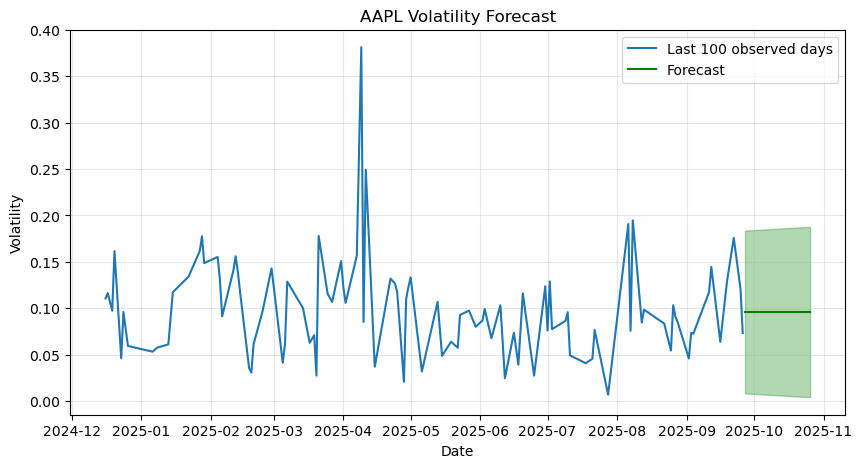

--- Auto ARIMA for NEE ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  746
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1266.845
Date:                Sun, 07 Dec 2025   AIC                          -2525.691
Time:                        20:35:20   BIC                          -2507.232
Sample:                             0   HQIC                         -2518.576
                                - 746                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0099      0.005      1.890      0.059      -0.000       0.020
ar.L1          0.8948      0.055     16.174      0.000       0.786       1.003
ma.L1         -0.8233    

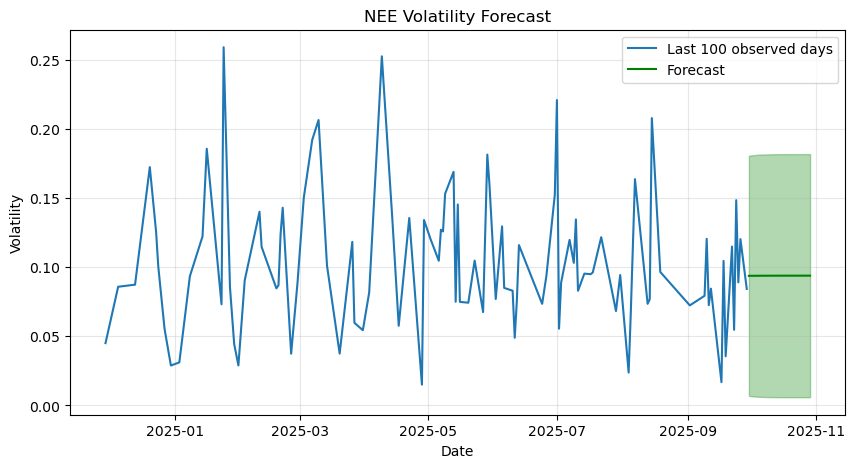

--- Auto ARIMA for LLY ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  756
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1246.578
Date:                Sun, 07 Dec 2025   AIC                          -2485.156
Time:                        20:35:23   BIC                          -2466.644
Sample:                             0   HQIC                         -2478.025
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0129      0.007      1.928      0.054      -0.000       0.026
ar.L1          0.8676      0.068     12.697      0.000       0.734       1.002
ma.L1         -0.7805    

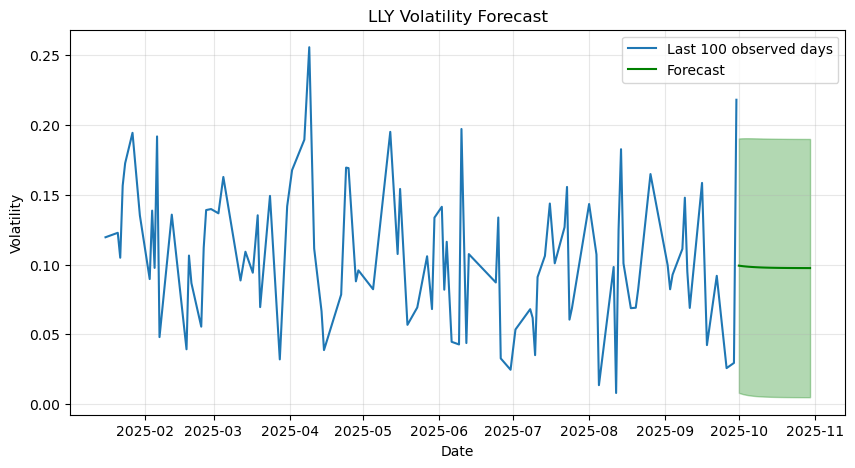

In [13]:

# ARIMA

def fit_and_plot_arima(df, name):
    print(f"--- Auto ARIMA for {name} ---")

    # Make data a series
    series = df['volatility'].values
    
    # Model
    model = auto_arima(series, seasonal=False, error_action='ignore', suppress_warnings=True)
    print(model.summary())
    
    # Forecast
    n_periods = 30
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    last_date = df['date'].iloc[-1]
    forecast_dates = [last_date + pd.Timedelta(days=x) for x in range(1, n_periods + 1)]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'][-100:], series[-100:], label='Last 100 observed days') # historic
    plt.plot(forecast_dates, forecast, label='Forecast', color='green') # forecast
    plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.3)
    plt.title(f"{name} Volatility Forecast")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


fit_and_plot_arima(aapl_vol, "AAPL")
fit_and_plot_arima(nee_vol, "NEE")
fit_and_plot_arima(lly_vol, "LLY")

## Trying GARCH

ARIMA is mean forcasting and is treating the volatility shocks as noise. GARCH is designed for volatility forecasting and should forecast the price shocks

In [14]:
from arch import arch_model

In [15]:
# Compute daily returns

def get_daily_returns(df):

    df = df[['timestamp', 'open', 'close']].dropna().copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    
    # Aggregation
    daily = df.groupby('date').agg(
        open=('open', 'first'),
        close=('close', 'last')
    ).reset_index()
    
    # Calculate Log Return
    daily['log_return'] = np.log(daily['close'] / daily['open'])
    daily['scaled_return'] = daily['log_return'] * 100
    
    return daily[['date', 'scaled_return']].dropna()

aapl_returns = get_daily_returns(aapl)
nee_returns = get_daily_returns(nee)
lly_returns = get_daily_returns(lly)


--- Fitting GARCH(1,1) for AAPL ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:          scaled_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2600.49
Distribution:                  Normal   AIC:                           5206.98
Method:            Maximum Likelihood   BIC:                           5222.81
                                        No. Observations:                 1444
Date:                Mon, Dec 08 2025   Df Residuals:                     1444
Time:                        11:23:37   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1309  7

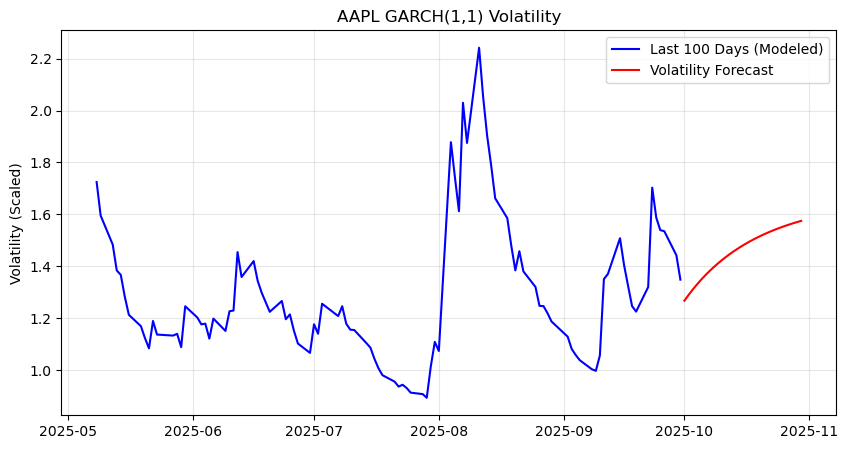


--- Fitting GARCH(1,1) for NEE ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:          scaled_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2616.87
Distribution:                  Normal   AIC:                           5239.73
Method:            Maximum Likelihood   BIC:                           5255.56
                                        No. Observations:                 1444
Date:                Mon, Dec 08 2025   Df Residuals:                     1444
Time:                        11:23:37   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.3078    

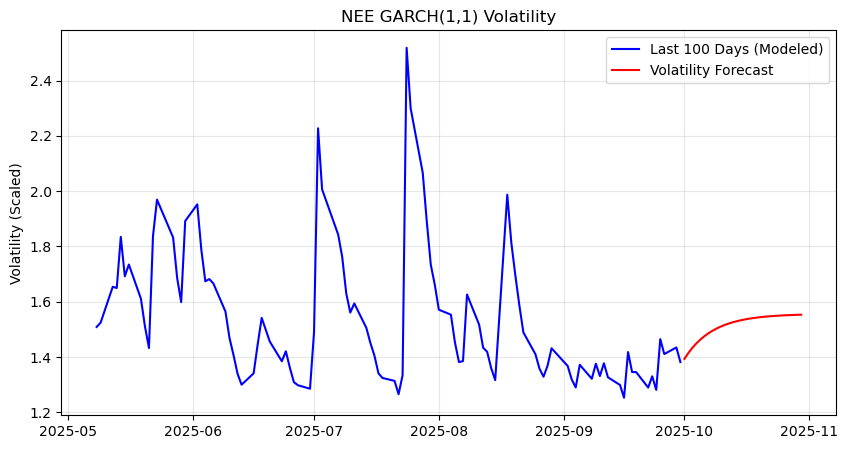


--- Fitting GARCH(1,1) for LLY ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:          scaled_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2749.35
Distribution:                  Normal   AIC:                           5504.70
Method:            Maximum Likelihood   BIC:                           5520.53
                                        No. Observations:                 1444
Date:                Mon, Dec 08 2025   Df Residuals:                     1444
Time:                        11:23:38   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.5354      0

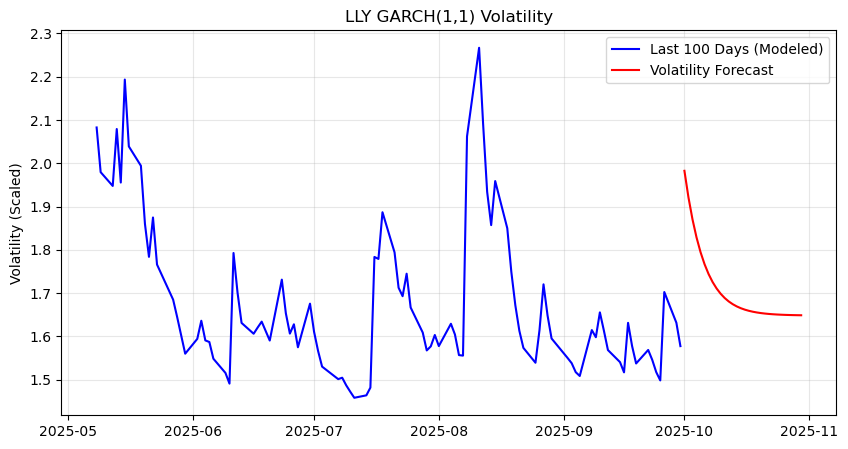

In [31]:
# GARCH
def fit_and_forecast_garch(df, ticker_name):
    print(f"\n--- Fitting GARCH(1,1) for {ticker_name} ---")
    
    # Model
    model = arch_model(df['scaled_return'], vol='Garch', p=1, q=1, mean='Zero')
    results = model.fit(disp='off')
    print(results.summary())
    
    # Forecast
    forecast_horizon = 30
    forecasts = results.forecast(horizon=forecast_horizon)
    pred_variance = forecasts.variance.values[-1, :]
    pred_volatility = np.sqrt(pred_variance)
    last_date = df['date'].iloc[-1]
    forecast_dates = [last_date + pd.Timedelta(days=x) for x in range(1, forecast_horizon + 1)]
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'][-100:], results.conditional_volatility[-100:], label='Last 100 Days (Modeled)', color='blue') #historic
    plt.plot(forecast_dates, pred_volatility, label='Volatility Forecast', color='red') #forecast
    plt.title(f"{ticker_name} GARCH(1,1) Volatility")
    plt.ylabel("Volatility (Scaled)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- 4. Run the Models ---
fit_and_forecast_garch(aapl_returns, "AAPL")
fit_and_forecast_garch(nee_returns, "NEE")
fit_and_forecast_garch(lly_returns, "LLY")


In [45]:
import numpy as np
import pandas as pd
from arch import arch_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

def optimize_garch_cv(vol_series, n_splits=5):
    """
    Finds best p, q using Time Series Cross-Validation.
    Metric: MSE of (Predicted Variance - Actual Squared Returns).
    """
    
    # Grid
    p_range = [1, 2, 3]
    q_range = [1, 2, 3]
    
    # TS data split
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    results = []

    print(f"{'p':<4} {'q':<4} {'Avg MSE':<15}")
    print("-" * 30)

    # Grid search
    for p in p_range:
        for q in q_range:
            mse_scores = []
            
            # CV "Folds"
            for train_idx, test_idx in tscv.split(vol_series):
                # Split data
                train_data = vol_series.iloc[train_idx]
                test_data = vol_series.iloc[test_idx]
                
                # Fit Model
                try:
                    model = arch_model(train_data, vol='Garch', p=p, q=q, mean='Zero')
                    res = model.fit(disp='off')
           
                    forecasts = res.forecast(horizon=len(test_data), reindex=False)
                    
                    pred_variance = forecasts.variance.values[-1]
                    
                    actual_variance_proxy = test_data ** 2
                    
                    mse = mean_squared_error(actual_variance_proxy, pred_variance)
                    mse_scores.append(mse)
                    
                except:
                    continue
            
            # Average score across all folds
            if mse_scores:
                avg_mse = np.mean(mse_scores)
                results.append({'p': p, 'q': q, 'score': avg_mse})
                print(f"{p:<4} {q:<4} {avg_mse:.4f}")

    results_df = pd.DataFrame(results)
    best_params = results_df.loc[results_df['score'].idxmin()]
    
    print("-" * 30)
    print(f"BEST PARAMS via CV: p={int(best_params.p)}, q={int(best_params.q)}")
    return int(best_params.p), int(best_params.q)

In [51]:

print("------ GARCH for AAPL -------")
best_p, best_q = optimize_garch_cv(aapl_vol['volatility'])
aapl_garch = arch_model(aapl_vol['volatility'], vol='Garch', p=best_p, q=best_q, mean='Zero')
aapl_res = aapl_garch.fit(disp='off')
print(aapl_res.summary())

------ GARCH for AAPL -------
p    q    Avg MSE        
------------------------------
1    1    0.0001
1    2    0.0001
1    3    0.0001
2    1    0.0001


/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002417. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001958. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids

2    2    0.0001
2    3    0.0001
3    1    0.0001
3    2    0.0001
3    3    0.0001
------------------------------
BEST PARAMS via CV: p=1, q=1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                633.042
Distribution:                  Normal   AIC:                          -1260.08
Method:            Maximum Likelihood   BIC:                          -1246.13
                                        No. Observations:                  775
Date:                Fri, Dec 12 2025   Df Residuals:                      775
Time:                        12:43:08   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0%

/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002417. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001958. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids

In [52]:
print("------ GARCH for NEE -------")
best_p, best_q = optimize_garch_cv(nee_vol['volatility'])
nee_garch = arch_model(nee_vol['volatility'], vol='Garch', p=best_p, q=best_q, mean='Zero')
nee_res = nee_garch.fit(disp='off')
print(nee_res.summary())

------ GARCH for NEE -------
p    q    Avg MSE        
------------------------------
1    1    0.0001
1    2    0.0001
1    3    0.0001
2    1    0.0001


/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003024. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002343. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids

2    2    0.0001
2    3    0.0001
3    1    0.0001
3    2    0.0001
3    3    0.0001
------------------------------
BEST PARAMS via CV: p=2, q=3
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                636.643
Distribution:                  Normal   AIC:                          -1261.29
Method:            Maximum Likelihood   BIC:                          -1233.60
                                        No. Observations:                  746
Date:                Fri, Dec 12 2025   Df Residuals:                      746
Time:                        12:43:17   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0%

/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002293. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0021. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [53]:
print("------ GARCH for LLY -------")
best_p, best_q = optimize_garch_cv(lly_vol['volatility'])
lly_garch = arch_model(lly_vol['volatility'], vol='Garch', p=best_p, q=best_q, mean='Zero')
lly_res = lly_garch.fit(disp='off')
print(lly_res.summary())

------ GARCH for LLY -------
p    q    Avg MSE        
------------------------------
1    1    0.0001
1    2    0.0001
1    3    0.0001
2    1    0.0001


/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003204. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002664. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids

2    2    0.0001
2    3    0.0001
3    1    0.0001
3    2    0.0001
3    3    0.0001
------------------------------
BEST PARAMS via CV: p=3, q=3
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                609.995
Distribution:                  Normal   AIC:                          -1205.99
Method:            Maximum Likelihood   BIC:                          -1173.59
                                        No. Observations:                  756
Date:                Fri, Dec 12 2025   Df Residuals:                      756
Time:                        12:43:23   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0%

/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002194. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/Users/abigailalpert/anaconda3/envs/cse217a/lib/python3.10/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003204. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids

- Apple: GARCH(3,2)
- NextEra: GARCH(2,2)
- Eli Lilly: GARCH(1,1)


--- Fitting GARCH(3, 2) for AAPL ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:          scaled_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2599.33
Distribution:                  Normal   AIC:                           5210.66
Method:            Maximum Likelihood   BIC:                           5242.31
                                        No. Observations:                 1444
Date:                Mon, Dec 08 2025   Df Residuals:                     1444
Time:                        11:24:31   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1449  

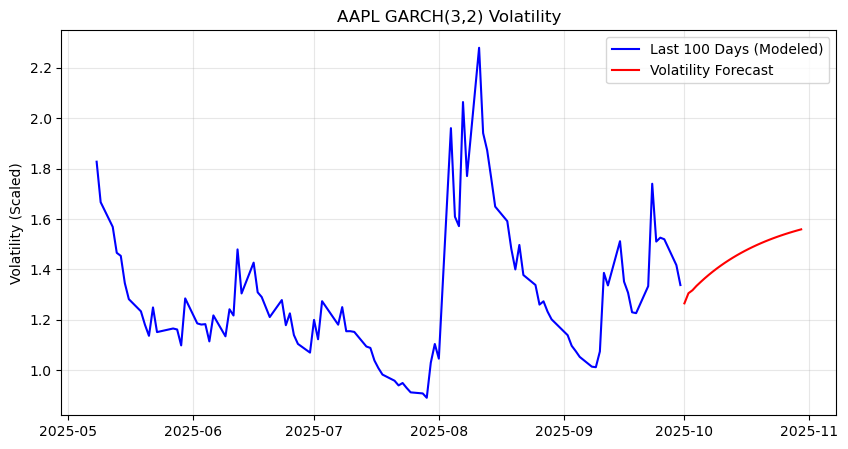


--- Fitting GARCH(2, 2) for NEE ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:          scaled_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2616.79
Distribution:                  Normal   AIC:                           5243.59
Method:            Maximum Likelihood   BIC:                           5269.96
                                        No. Observations:                 1444
Date:                Mon, Dec 08 2025   Df Residuals:                     1444
Time:                        11:24:31   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.4839   

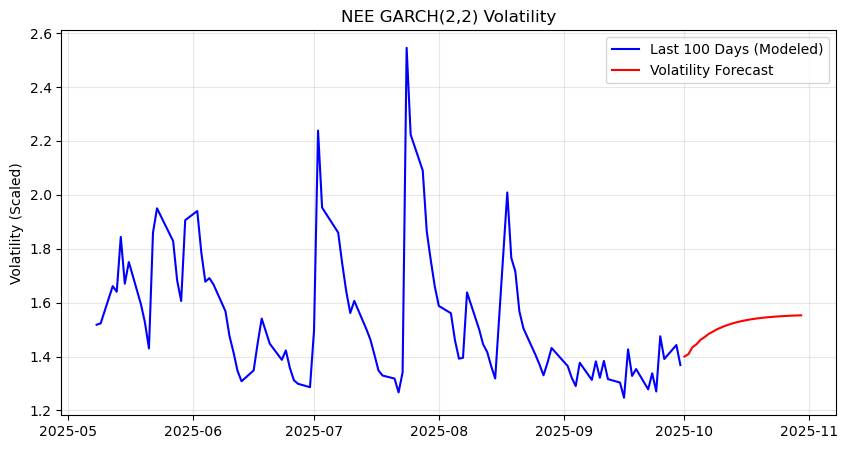


--- Fitting GARCH(1, 1) for LLY ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:          scaled_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2749.35
Distribution:                  Normal   AIC:                           5504.70
Method:            Maximum Likelihood   BIC:                           5520.53
                                        No. Observations:                 1444
Date:                Mon, Dec 08 2025   Df Residuals:                     1444
Time:                        11:24:32   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.5354      

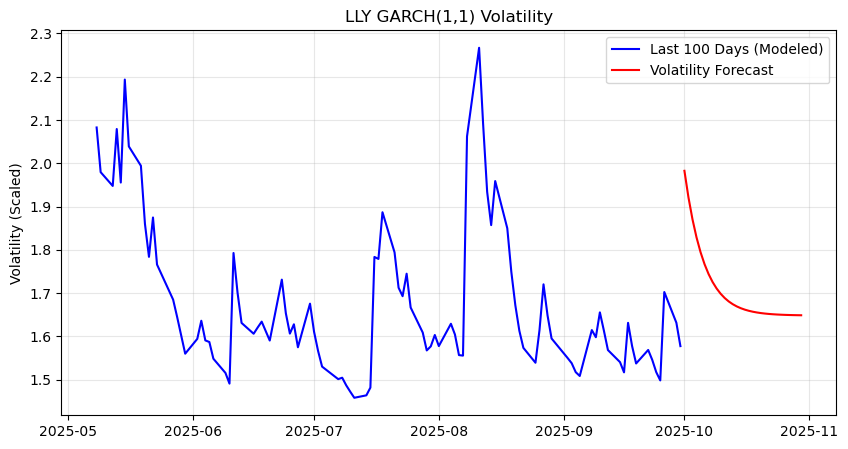

In [33]:
# GARCH
def fit_and_forecast_garch_pq(df, ticker_name, p, q):
    print(f"\n--- Fitting GARCH({p}, {q}) for {ticker_name} ---")
    
    # Model
    model = arch_model(df['scaled_return'], vol='Garch', p=p, q=q, mean='Zero')
    results = model.fit(disp='off')
    print(results.summary())
    
    # Forecast
    forecast_horizon = 30
    forecasts = results.forecast(horizon=forecast_horizon)
    pred_variance = forecasts.variance.values[-1, :]
    pred_volatility = np.sqrt(pred_variance)
    last_date = df['date'].iloc[-1]
    forecast_dates = [last_date + pd.Timedelta(days=x) for x in range(1, forecast_horizon + 1)]
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'][-100:], results.conditional_volatility[-100:], label='Last 100 Days (Modeled)', color='blue') #historic
    plt.plot(forecast_dates, pred_volatility, label='Volatility Forecast', color='red') #forecast
    plt.title(f"{ticker_name} GARCH({p},{q}) Volatility")
    plt.ylabel("Volatility (Scaled)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- 4. Run the Models ---
fit_and_forecast_garch_pq(aapl_returns, "AAPL", 3, 2)
fit_and_forecast_garch_pq(nee_returns, "NEE", 2, 2)
fit_and_forecast_garch_pq(lly_returns, "LLY", 1, 1)